<a href="https://colab.research.google.com/github/AasthaKaur/Capstone-Project-Test/blob/main/testing_the_articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# ============================
# Fiscal News Index (FNI) Pipeline
# ============================

# Install dependencies (Colab usually has nltk & sklearn pre-installed)
!pip install pdfplumber nltk pandas matplotlib

import os
import re
import pdfplumber
import pandas as pd
import nltk
from collections import Counter
import matplotlib.pyplot as plt

nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
# ============================
# STEP 1: Extract Text from PDFs
# ============================

def extract_text_from_pdf(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() or ""
    return text

# Example: Place PDFs in /content/news_pdfs/ in Colab
pdf_dir = "/content/"
all_articles = []

for file in os.listdir(pdf_dir):
    if file.endswith(".pdf"):
        text = extract_text_from_pdf(os.path.join(pdf_dir, file))
        # Split into sentences/articles (you can refine this depending on dataset structure)
        articles = nltk.sent_tokenize(text)
        for i, a in enumerate(articles):
            all_articles.append({"source": file, "article_id": f"{file}_{i}", "text": a})

df_articles = pd.DataFrame(all_articles)
print("Extracted Articles:", df_articles.shape)
df_articles.head()


Extracted Articles: (9834, 3)


,source,article_id,text
0,ProQuestDocuments-2025-08-16_1_fiscalpolicy_la...,ProQuestDocuments-2025-08-16_1_fiscalpolicy_la...,Document 1 of 222\nU.S. News: BLS Pick Has For...
1,ProQuestDocuments-2025-08-16_1_fiscalpolicy_la...,ProQuestDocuments-2025-08-16_1_fiscalpolicy_la...,"Kiernan, Paul."
2,ProQuestDocuments-2025-08-16_1_fiscalpolicy_la...,ProQuestDocuments-2025-08-16_1_fiscalpolicy_la...,ProQuest document link\nFULL TEXT\nConservativ...
3,ProQuestDocuments-2025-08-16_1_fiscalpolicy_la...,ProQuestDocuments-2025-08-16_1_fiscalpolicy_la...,Antoni sometimes jokes on social media that th...
4,ProQuestDocuments-2025-08-16_1_fiscalpolicy_la...,ProQuestDocuments-2025-08-16_1_fiscalpolicy_la...,President Trump this week tapped Antoni to run...


In [6]:
# ============================
# STEP 2: Define Fiscal Keywords Dictionary
# ============================

fiscal_dictionary = {
    "taxation": ["tax", "tax cut", "tax increase", "income tax", "corporate tax", "capital gains"],
    "spending": ["budget", "spending", "appropriation", "expenditure", "outlay"],
    "deficit_debt": ["deficit", "surplus", "debt ceiling", "public debt", "treasury borrowing"],
    "programs": ["stimulus", "relief package", "infrastructure bill", "child tax credit"],
    "policy_process": ["budget resolution", "reconciliation", "omnibus", "continuing resolution"]
}

# Flatten keywords into one list
all_keywords = [kw for group in fiscal_dictionary.values() for kw in group]

In [7]:
# ============================
# STEP 3: Classification Function
# ============================

def classify_article(text, keywords):
    text_clean = text.lower()
    count = 0
    for kw in keywords:
        if re.search(rf"\b{kw}\b", text_clean):
            count += 1
    return 1 if count >= 2 else 0  # Require at least 2 matches

df_articles["is_fiscal"] = df_articles["text"].apply(lambda x: classify_article(x, all_keywords))

print("Fiscal Articles Found:", df_articles["is_fiscal"].sum())

Fiscal Articles Found: 447


In [8]:
# ============================
# STEP 4: Build Fiscal News Index (Weekly)
# ============================

# For demo: Fake publication dates (replace with real metadata if available)
df_articles["pub_date"] = pd.date_range(start="2024-01-01", periods=len(df_articles), freq="D")

df_articles["week"] = df_articles["pub_date"].dt.to_period("W").apply(lambda r: r.start_time)

fni = df_articles.groupby("week").agg(
    fiscal_count=("is_fiscal", "sum"),
    total_count=("is_fiscal", "count")
).reset_index()

fni["fni_raw"] = fni["fiscal_count"] / fni["total_count"]
fni["fni_index"] = 100 * fni["fni_raw"] / fni["fni_raw"].mean()

print(fni.head())

        week  fiscal_count  total_count   fni_raw   fni_index
0 2024-01-01             0            7  0.000000    0.000000
1 2024-01-08             0            7  0.000000    0.000000
2 2024-01-15             1            7  0.142857  314.317673
3 2024-01-22             0            7  0.000000    0.000000
4 2024-01-29             0            7  0.000000    0.000000


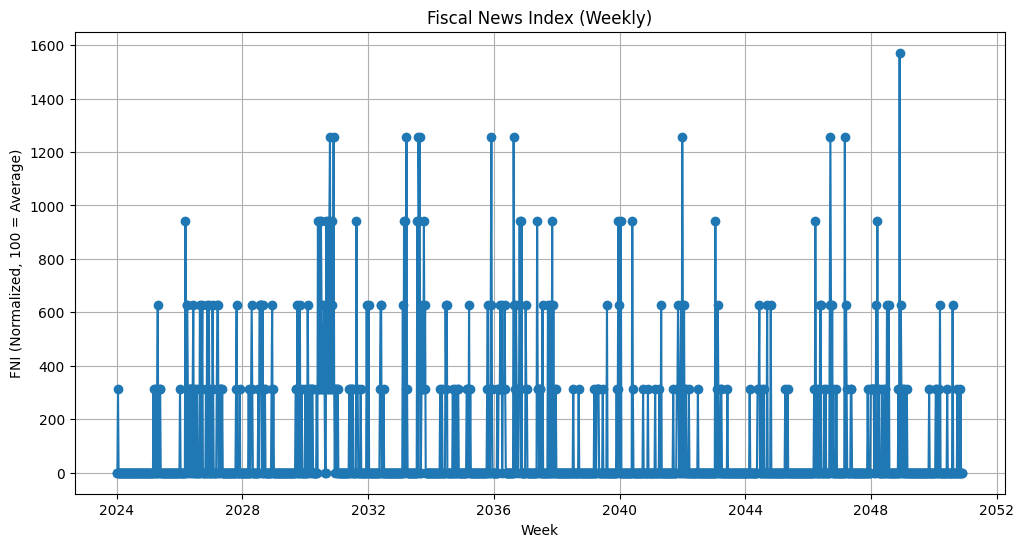

In [9]:
# ============================
# STEP 5: Plot Fiscal News Index
# ============================

plt.figure(figsize=(12,6))
plt.plot(fni["week"], fni["fni_index"], marker="o")
plt.title("Fiscal News Index (Weekly)")
plt.xlabel("Week")
plt.ylabel("FNI (Normalized, 100 = Average)")
plt.grid(True)
plt.show()